## Combined ADCP and CTD particle test with CMEMS data

In [1]:
from datetime import timedelta
import numpy as np
import pyproj

from parcels import (
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

### Read sample input data

In [2]:
# Load the CMEMS data (3 days manually downloaded)
dataset_folder = "/nethome/0448257/Data"
filenames = {
    "U": f"{dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc"}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# add bathymetry data to the fieldset for CTD cast
bathymetry_file = f"{dataset_folder}/GLO-MFC_001_024_mask_bathy.nc"
bathymetry_variables = ('bathymetry', 'deptho')
bathymetry_dimensions = {'lon': 'longitude', 'lat': 'latitude'}
bathymetry_field = Field.from_netcdf(bathymetry_file, bathymetry_variables, bathymetry_dimensions)
fieldset.add_field(bathymetry_field)
fieldset.add_constant('z_start',0.5) #TODO
fieldset.computeTimeChunk(0,1)

In [8]:
# set initial location #TODO should be input to function or come from leafmap 
from shapely.geometry import Point, Polygon

coords_input = [[-94.394531, -4.390229], [-106.523437, -0.175781], [-124.541016, -6.053161], [-140.537109, -0.527336]]

poly = Polygon([(-170, 5), (-170, -10), (-75, -10), (-75, 5)])
coords = []
for coord in coords_input:
    if poly.contains(Point(coord)):
        coords.append(coord)

[[-94.394531, -4.390229], [-106.523437, -0.175781], [-124.541016, -6.053161], [-140.537109, -0.527336]]


### Determine ship course as intermediate points between CTD stations

In [3]:
# Initialize lists to store intermediate points
sample_lons = []
sample_lats = []

# Loop over station coordinates and calculate intermediate points along great circle path
i = 0
for i in (range(len(coords)-1)):
    startlong = coords[i][0]
    startlat = coords[i][1]
    endlong = coords[i+1][0]
    endlat = coords[i+1][1]

    # calculate line string along path with segments every TODO hour or 5 min = 3.6*60*5 = 1080 m, for now 5 midpoints
    g = pyproj.Geod(ellps='WGS84')
    # r = g.inv_intermediate(startlong, startlat, endlong, endlat, del_s = 1080)
    r = g.inv_intermediate(startlong, startlat, endlong, endlat, initial_idx=0, return_back_azimuth=False, npts=5)
    # store all intermediate points
    sample_lons.append(r.lons) # stored as a list of arrays
    sample_lats.append(r.lats)

# initial_idx will add begin point to each list (but not end point to avoid dubbling) so add final endpoint manually
sample_lons = np.append(np.hstack(sample_lons), endlong)
sample_lats = np.append(np.hstack(sample_lats), endlat)

### Define particles and sampling functions 

In [4]:
# Create ADCP like particles to sample the ocean
class ADCPParticle(JITParticle):
    """Define a new particle class that does ADCP like measurements"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# define ADCP sampling function from Usample and Vsample (because of A grid)
def SampleVel(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)
    # particle.V = fieldset.V.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

# Create CTD like particles to sample the ocean
class CTDParticle(JITParticle):
    """Define a new particle class that does CTD like measurements"""
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)
    raising = Variable("raising", dtype=np.int32, initial=0.0)

# define function lowering and raising CTD
def CTDcast(particle, fieldset, time):
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    vertical_speed = 1.0  # sink and rise speed in m/s

    if particle.raising == 0:
        # Sinking with vertical_speed until near seafloor
        particle_ddepth = vertical_speed * particle.dt
        if particle.depth >= (seafloor - 20):
            particle.raising = 1

    elif particle.raising == 1:
        # Rising with vertical_speed until depth is 1.5 m
        while particle.depth > 1.5:
            particle_ddepth = -vertical_speed * particle.dt  
            if particle.depth <= 1.5:
                # to break the loop ...
                particle.state = 4
                print("CTD cast finished")

# define function sampling Salinity
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

### Run simulation

In [5]:
# Create ADCP like particle set TODO accurate depths
depthnum = 5
# Initiate ADCP like particle set
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=ADCPParticle, lon=np.full(depthnum,sample_lons[0]), lat=np.full(depthnum,sample_lats[0]), depth=np.linspace(5, 1000, num=depthnum), time=0
)

# create a ParticleFile to store the ADCP output
adcp_output_file = pset.ParticleFile(name=".results/sailship_adcp.zarr")

# TODO use total time in setting appropriate time for ADCP particles?
total_time = 0

# initialize CTD station number
ctd = 0
ctddt = timedelta(seconds=120) # timestep of CTD output (for speed-up)

# run the model for the length of the sample_lons list
for i in range(len(sample_lons)):

    # set the ADCP particle lon and lat
    pset.lon[:] = sample_lons[i]
    pset.lat[:] = sample_lats[i]

    print(i, pset)

    # execute the kernels to sample U and V
    pset.execute(SampleVel, dt=1, runtime=1, output_file=adcp_output_file)
    print(f"Writing time {pset.time[0]}")

    # check if we are at a CTD station
    if sample_lons[i] == coords[ctd][0] and sample_lats[i] == coords[ctd][1]:
        print('CTD time!')
        ctd += 1

        # release CTD particle
        pset_CTD = ParticleSet(fieldset=fieldset, pclass=CTDParticle, lon=sample_lons[i], lat=sample_lats[i], depth=fieldset.z_start, time=total_time)

        # create a ParticleFile to store the CTD output
        ctd_output_file = pset_CTD.ParticleFile(name=f"CTD_test_{ctd}.zarr", outputdt=ctddt)

        # record the temperature and salinity of the particle
        pset_CTD.execute([CTDcast, SampleS, SampleT], runtime=timedelta(hours=5), dt=ctddt, output_file=ctd_output_file)
        total_time = pset_CTD.time[0]
        print(total_time)

    # update the particle time
    total_time += timedelta(hours=1).total_seconds()
    pset.time[:] = total_time


0 P[0](lon=-94.394531, lat=-4.390229, depth=5.000000, U=0.000000, V=0.000000, time=0.000000)
P[1](lon=-94.394531, lat=-4.390229, depth=253.750000, U=0.000000, V=0.000000, time=0.000000)
P[2](lon=-94.394531, lat=-4.390229, depth=502.500000, U=0.000000, V=0.000000, time=0.000000)
P[3](lon=-94.394531, lat=-4.390229, depth=751.250000, U=0.000000, V=0.000000, time=0.000000)
P[4](lon=-94.394531, lat=-4.390229, depth=1000.000000, U=0.000000, V=0.000000, time=0.000000)
INFO: Output files are stored in .results/sailship_adcp.zarr.
100%|██████████| 1.0/1.0 [00:02<00:00,  2.62s/it]
Writing time 0.0
CTD time!
INFO: Output files are stored in CTD_test_1.zarr.
 23%|██▎       | 4080.0/18000.0 [01:45<04:55, 47.18it/s]

In [ ]:
import xarray as xr
# Open and combine the CTD output files
da = xr.open_zarr("./results/CTD_test_1.zarr")
for i in range(2, ctd+1):
    da = xr.concat([da, xr.open_zarr(f"./results/CTD_test_{i}.zarr")], "obs")
# Write the combined output to a netcdf file
da.to_netcdf("./results/CTD_test.nc", mode="w")
da.close()

/nethome/0448257/.conda/envs/Parcels/lib/python3.11/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


### Do some plotting to check output

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Open output and read to x, y, z
ds = xr.open_zarr("./results/sailship_adcp.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

FileNotFoundError: No such file or directory: '/storage/home/0448257/Virtual_ship_classroom/results/sailship_adcp.zarr'

### Plot CTD casts

/nethome/0448257/.conda/envs/Parcels/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


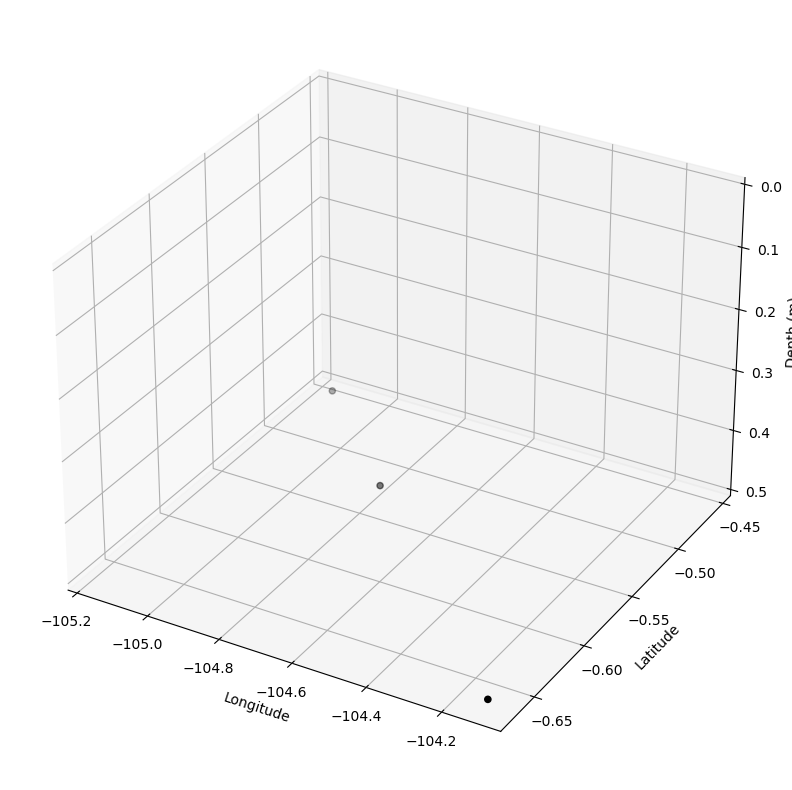

In [ ]:
# Open output and read to x, y, z
ds = xr.open_dataset("./results/CTD_test.nc")
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
# salinity = ds["salinity"][:].squeeze()
# temperature = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=U, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [ ]:

da = xr.open_zarr("CTD_test_2.zarr")
print(da)
da.close()
print(ctd)

<xarray.Dataset>
Dimensions:     (trajectory: 1, obs: 1)
Coordinates:
  * obs         (obs) int32 0
  * trajectory  (trajectory) int64 32
Data variables:
    U           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    V           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2
3
